# Detailed Statistics

## Overview

I previously created a interactive dashboard displaying several statistics about PWHL players. The scripts necessary to obtain the data it requires and run it, `step1_get_stats.py` and `step2_run_dashboard.py`, are available in this repository.

![The upper part of an interactive dashboard titled "PWHL Player Statistics", showing charts aggregating statictics about each of the six teams’ players](./visual_samples/2025-03-16_currentseason_top.png)

It was very interesting to look at these aggregated statistics and I learned more about the league and each of its teams, I would like to create a dashboard to display detailed statistics about my favorite players and their evolution over time.

This notebook will document the preparation process for the creation of this new dashboard.

## Exploring the PWHL website

### Webpage overview

I am interested about getting specific stats about players and their contribution to each match. Each player has a page like [this one](https://www.thepwhl.com/en/stats/player/31/5), with a very useful table at the end:

![A table showing statistics for Marie-Philip Poulin, with each row representing a game from the 2024-2025 season](./img/2025-04-06_PlayerStatsTable.png)

Each player’s page shows a photo of them along with various data points such as their position, height and birthdate.

Underneath is a biography section which may or may not contain text, typically a list of hockey-related achievements.

Underneath are several tables. First, under the "FirstName LastName Player Stats" subtitle, are two tables containing summary statistics for the regular and playoffs seasons the player participated in, if any. These table are absent if they would be empty. Then, under the "FirstName LastName Game by Game" subtitle, the game by game table, which is present even if empty.

### URL

Each player’s URL looks like this: `https://www.thepwhl.com/en/stats/player/1/` The number of course changes depending on the player. Numbers between 1 and 233 are assigned. Inputting an out of range number will result in a webpage displaying "NO DATA WAS FOUND".

A number can be added to the end of the URL to pull statistics from an earlier season (ex.: `https://www.thepwhl.com/en/stats/player/1/1`). If attempting to pull information from a season the player did not participate in, the page will default to displaying statistics for the current season.

### Seasons

There is no summary table for preseasons.

Above the game by game table is a dropdown menu listing the seasons the player participated in.

Certain players (ex.: [Nikki Nightengale](https://www.thepwhl.com/en/stats/player/120)) have no statistics. This appears to be because they are reserve players who have yet to play in an official PWHL game.

### Available data

The game by game table for a skater has the following columns:

- **Game**, indicating which two teams played and where. For example, `OTT @ MTL` indicates that the Ottawa and Montreal team played on Montreal’s ice.
- **Date**, in the `YYYY-MM-DD` format.
- **G**, for the number of goals scored by the player.
- **A**, for their number of assists.
- **PTS**, for the number of points they obtained.
- **+/-**, for the plus-minus, which corresponds to the difference between the number of goals scored by their team and the number of goals scored by the opposing team while the player was on the ice.
- **Shots**, for number of shots to the goal the skater made. Solely shots that were goals or would have been if not blocked/deviated are counted. Shots that hit a pole or missed the goal are not counted.
- **PIM**, for their penalty minutes.
- **FO**, for their number of faceoffs.
- **WF%**, for their won faceoffs percentage. If the player did not participate in any faceoffs during the game, this value is set to 0.
- **PPG**, or "power play goals", for the number of goals scored by the skater while their team had more players on the ice than the opposing team.
- **SHG**, or "short handed goals", for the number of goals scored by the skater while their team had less players on the ice than the opposing team.
- **GWG**, or "game winning goals", TODO check the PWHL’s definition of this since it may vary per league
- **SOG**, or "shootout goals", TODO
- **SOA**, or "shootout attempts", TODO
- **TOI**, for the time they spent on the ice, in the `MM:SS` format.
- **Hits**, for the number of body checks the skater delivered to an opponent in possession of the puck.

The game by game table for a goalie has the following columns:

- **Game**, same as above.
- **Date**, same as above.
- **Min**, for the "minutes played", equivalent to *TOI* above.
- **SA**, or "shots against", for the number of shots to the goal (calculated as stated above for the *Shots* column) while the goalie was on the ice.
- **GA**, or "goals against", for the number of these shots that were goals for the opposing team.
- **SVS**, or "saves", corresponding to the difference between *SA* and *GA*.
- **W**, or "wins", 1 if the game was won by the goalie’s team, 0 otherwise.
- **L**, or "loss", 1 if the game was loss by the goalie’s team during regular time, 0 otherwise.
- **OT**, or "overtime loss", 1 if the game was loss by the goalie’s team during overtime, 0 otherwise.
- **SOL**, or "shootout loss", 1 if the game was loss by the goalie’s team during shootouts, 0 otherwise
- **GAA**, or "goals against average", the amount of goals against per hour on the ice
- **SV%**, or "save percentage", for the ratio between the shots (*SA*) and saves (*SVS*). Despite the label indicating that this is a percentage, it is formatted as a decimal greater than 0 and lower or equal to 1.
- **SO**, or "shotout", 0 if any goal was scored againt the goalie (*GA*), 1 otherwise.
- **G**, same as above.
- **A**, same as above.
- **PIM**, same as above.

NOTE 1: In cases where the goalie was changed during the match, only one goalie, the "main goalie" for the match gets a 1 in the *W*, *L*, *OT* or *SOL* column. It is therefore possible for the total of these columns to be lower than the amount of games played. TODO check how the leagues determine which goalie gets the 1.

NOTE 2: In cases where a goalie was not the "main goalie" for a match, the *SO* value will be 0 even if no goal was scored against the goalie.

## Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Statistics for one skater

I plan to create a dashboard that will have a dropdown menu to select a specific players. There will be three versions of the dashboard: one for forward players, one for defense players and one for goalies.

I decided to go with my favorite defense player first: Erin Ambrose. She plays for the Montreal Victoire and has participated in every PWHL season so far.

### Webscraping

Like the other statistics pages on the PWHL website, her page loads without the table, and then it load the table, so I will need to use WebDriver.

I used it in my script `step1_get_stats.py`, so let’s look at the function I was using and give it Ambrose’s page’s URL:

In [13]:
def scrape_stats_page(url):
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the table to load
    try:
        table = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, '//table'))
        )
        rows = table.find_elements(By.TAG_NAME, 'tr')
        data = []
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, 'td')
            data.append([col.text for col in cols])
        df = pd.DataFrame(data)
    finally:
        driver.quit()
    return df

In [17]:
df = scrape_stats_page("https://www.thepwhl.com/en/stats/player/83").dropna()
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2,2024-25 Regular Season,Montréal Victoire,26,0,12,12,9,4,3,7,42.9,0,0,0,1,4,25.0,40,0.0
3,2024 Regular Season,PWHL Montreal,24,4,14,18,5,4,0,0,0.0,1,0,0,1,2,50.0,47,8.5
4,Total,,50,4,26,30,14,8,3,7,42.9,1,0,0,2,6,33.3,87,4.6
7,2024 Playoffs,PWHL Montreal,3,0,2,2,-2,0,0,0,0.0,0,0,0,0,0,0.0,10,0.0
8,Total,,3,0,2,2,-2,0,0,0,0.0,0,0,0,0,0,0.0,10,0.0


I now have the contents of the two summary tables. That’s pretty cool, but I want the game by game. I inspected the HTML and found that the game by game table is inside an HTML `div` within another `div` within another `div` within a `div` which has a "data-head-id" attribute whose value is "player_game_by_game".

Therefore, let’s change `EC.presence_of_element_located((By.XPATH, '//table'))` to `EC.presence_of_element_located((By.XPATH, '//div[@data-head-id="player_game_by_game"]//table'))`.

In [49]:
def scrape_stats_page_gbg(url):
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the table to load
    try:
        table = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, "//div[@data-head-id='player_game_by_game']//table"))
        )
        rows = table.find_elements(By.TAG_NAME, 'tr')
        data = []
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, 'td')
            data.append([col.text for col in cols])
        df = pd.DataFrame(data)
    finally:
        driver.quit()
    return df

In [51]:
df = scrape_stats_page_gbg("https://www.thepwhl.com/en/stats/player/83").dropna()
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,OTT @ MTL,2024-11-30,0,1,1,0,5,0,0,0,0,0,0,0,1,24:19,2,
2,NY @ MTL,2024-12-04,0,0,0,-1,1,2,0,0,0,0,0,0,0,21:45,0,
3,MTL @ OTT,2024-12-06,0,0,0,1,3,0,3,33.3,0,0,0,0,0,21:56,0,
4,MTL @ TOR,2024-12-21,0,0,0,3,2,0,0,0,0,0,0,0,0,25:14,4,
5,MTL @ MIN,2024-12-28,0,0,0,2,1,0,0,0,0,0,0,0,0,19:11,0,
6,BOS @ MTL,2024-12-30,0,0,0,1,1,0,0,0,0,0,0,0,0,19:52,0,
7,MTL @ BOS,2025-01-05,0,1,1,1,0,0,0,0,0,0,0,0,1,24:31,0,
8,MTL @ TOR,2025-01-08,0,1,1,0,2,0,1,100.0,0,0,0,0,0,20:55,1,
9,MTL @ MIN,2025-01-12,0,0,0,-1,1,0,1,100.0,0,0,0,0,0,22:55,1,
10,MIN @ MTL,2025-01-17,0,3,3,1,0,0,0,0,0,0,0,0,0,20:36,0,


I now have Ambrose’s game by game statistics for the current season, but I want ALL of her statistics.

Now, I could go and get the statistics for all seasons (numbered 1 to 5) because she did play during each one of them, but it won’t work like that for every player. I noted earlier that there is a dropdown menu that loads with options corresponding to the seasons the player participated in, and only those seasons.

So the plan is:
1. Load the player’s page with no specific season selected
2. Grab the values (integers) corresponding to the seasons the player actually participated in as well as the player’s name
3. Create a dataframe
4. Iterate through the seasons the player participated in, scraping their stats for each and adding them to the dataframe

I already have a function to scrape table data, so let’s create one for scraping dropdown menu values.

In [134]:
from selenium.webdriver.support.ui import Select

def get_element_attributes(element):
    attributes = {}
    for attribute in element.get_property('attributes'):
        attributes[attribute['name']] = attribute['value']
    return attributes

def scrape_seasons_played(url):
    data_dicts = []
    data = []
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the dropdown menu to load
    try:
        select = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, "//select"))
        )
        select = Select(select)
        dropdown_options = select.options
        for option in dropdown_options:
            data_dicts.append(get_element_attributes(option))
        for dict in data_dicts:
            data.append(dict["value"])
    finally:
        driver.quit()
    return data

In [136]:
seasons_list = scrape_seasons_played("https://www.thepwhl.com/en/stats/player/83")
seasons_list

['5', '4', '3', '1', '2']

Alright. If enough of the page has loaded for the dropdown to be there, the name should also be there, so I should be able to grab it in the same function.

In [204]:
from selenium.webdriver.support.ui import Select

def get_element_attributes(element):
    attributes = {}
    for attribute in element.get_property('attributes'):
        attributes[attribute['name']] = attribute['value']
    return attributes

def scrape_name_and_seasons_played(url):
    data_dicts = []
    data = []
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the dropdown menu to load
    try:
        # getting season numbers
        select = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, "//select"))
        )
        select = Select(select)
        dropdown_options = select.options
        for option in dropdown_options:
            data_dicts.append(get_element_attributes(option))
        for dict in data_dicts:
            data.append(dict["value"])
        # getting player name
        str1 = "::playerInfo.firstName +' '+ playerInfo.lastName"
        str2 = f'//h1[@ng-bind="{str1}"]'
        name_h1 = driver.find_element(By.XPATH, str2).text
    finally:
        driver.quit()
    return [name_h1, data]

In [206]:
name, seasons_list = scrape_name_and_seasons_played("https://www.thepwhl.com/en/stats/player/83")
print(name)
print(seasons_list)

ERIN AMBROSE
['5', '4', '3', '1', '2']


Now that I did that, I realize I should also pull the position because I will want the dashboard to look different based on player position.

In [217]:
def scrape_name_and_seasons_played(url):
    data_dicts = []
    data = []
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the dropdown menu to load
    try:
        # getting season numbers
        select = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, "//select"))
        )
        select = Select(select)
        dropdown_options = select.options
        for option in dropdown_options:
            data_dicts.append(get_element_attributes(option))
        for dict in data_dicts:
            data.append(dict["value"])
        # getting player name
        str1 = "::playerInfo.firstName +' '+ playerInfo.lastName"
        str2 = f'//h1[@ng-bind="{str1}"]'
        name_h1 = driver.find_element(By.XPATH, str2).text
        # getting player position
        pos_span = driver.find_element(By.XPATH, "//span[@ng-bind='playerInfo.position']").text
    finally:
        driver.quit()
    return [name_h1, pos_span, data]

In [219]:
name, position, seasons_list = scrape_name_and_seasons_played("https://www.thepwhl.com/en/stats/player/83")
print(name)
print(position)
print(seasons_list)

ERIN AMBROSE
D
['5', '4', '3', '1', '2']


### Script creation

I should now be able to create a script which will scrape Ambrose’s name, her position, the seasons she played and her stats for each game, put all that information into a dataframe and save that dataframe to a CSV file.

In [37]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select

In [39]:
AMBROSE_URL = "https://www.thepwhl.com/en/stats/player/83/"

def scrape_stats_page_gbg(url):
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the table to load
    try:
        table = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, "//div[@data-head-id='player_game_by_game']//table"))
        )
        rows = table.find_elements(By.TAG_NAME, 'tr')
        data = []
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, 'td')
            data.append([col.text for col in cols])
        df = pd.DataFrame(data)
    finally:
        driver.quit()
    return df

def get_element_attributes(element):
    attributes = {}
    for attribute in element.get_property('attributes'):
        attributes[attribute['name']] = attribute['value']
    return attributes

def scrape_name_and_seasons_played(url):
    data_dicts = []
    data = []
    # set up the WebDriver
    driver = webdriver.Edge() #EDIT THIS LINE if not using Edge <<<<<<<<<<<<<<<<<<<< IMPORTANT <<<<<<<<<<<<<<<<<<<<
    # open the webpage
    driver.get(url)
    # wait for the dropdown menu to load
    try:
        # getting season numbers
        select = WebDriverWait(driver, 2).until(
            EC.presence_of_element_located((By.XPATH, "//select"))
        )
        select = Select(select)
        dropdown_options = select.options
        for option in dropdown_options:
            data_dicts.append(get_element_attributes(option))
        for dict in data_dicts:
            data.append(dict["value"])
        # getting player name
        str1 = "::playerInfo.firstName +' '+ playerInfo.lastName"
        str2 = f'//h1[@ng-bind="{str1}"]'
        name_h1 = driver.find_element(By.XPATH, str2).text
        # getting player position
        pos_span = driver.find_element(By.XPATH, "//span[@ng-bind='playerInfo.position']").text
    finally:
        driver.quit()
    return [name_h1, pos_span, data]

In [41]:
name, position, seasons_played = scrape_name_and_seasons_played(AMBROSE_URL)

In [66]:
def get_season_stats(player_url, seasons):
    temp_df = pd.DataFrame()
    for s in seasons:
        season_df = scrape_stats_page_gbg(player_url + str(s))
        season_df["season"] = s
        temp_df = pd.concat([temp_df, season_df])
    return temp_df

In [43]:
df = get_season_stats(AMBROSE_URL, seasons_played).dropna()

In [44]:
df["name"] = name
df["position"] = position

In [45]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,name,position
1,OTT @ MTL,2024-11-30,0,1,1,0,5,0,0,0,0,0,0,0,1,24:19,2,,ERIN AMBROSE,D
2,NY @ MTL,2024-12-04,0,0,0,-1,1,2,0,0,0,0,0,0,0,21:45,0,,ERIN AMBROSE,D
3,MTL @ OTT,2024-12-06,0,0,0,1,3,0,3,33.3,0,0,0,0,0,21:56,0,,ERIN AMBROSE,D
4,MTL @ TOR,2024-12-21,0,0,0,3,2,0,0,0,0,0,0,0,0,25:14,4,,ERIN AMBROSE,D
5,MTL @ MIN,2024-12-28,0,0,0,2,1,0,0,0,0,0,0,0,0,19:11,0,,ERIN AMBROSE,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,MTL @ NY,2025-03-12,0,1,1,-1,1,0,0,0,0,0,0,0,0,21:28,1,,ERIN AMBROSE,D
23,MTL @ BOS,2025-03-18,0,0,0,-1,2,0,0,0,0,0,0,1,0,23:23,1,,ERIN AMBROSE,D
24,TOR @ MTL,2025-03-23,0,0,0,-1,2,0,0,0,0,0,0,0,0,24:28,0,,ERIN AMBROSE,D
25,MTL @ MIN,2025-03-26,0,0,0,0,0,0,0,0,0,0,0,0,0,19:56,1,,ERIN AMBROSE,D


Now that I have what I want, time to generalize the method and try it with a different defense player: Renata Fast, whose page is numbered 67.

In [47]:
def get_player_gbg(num):
    url = "https://www.thepwhl.com/en/stats/player/" + str(num) + "/"
    name, position, seasons_played = scrape_name_and_seasons_played(url)
    df = get_season_stats(url, seasons_played).dropna()
    df["name"] = name
    df["position"] = position
    return df

In [48]:
df = get_player_gbg(67)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,name,position
1,BOS @ TOR,2024-11-30,0,1,1,2,1,0,0,0,0,0,0,0,0,26:21,1,,RENATA FAST,D
2,TOR @ OTT,2024-12-03,0,1,1,0,2,0,0,0,0,0,0,0,0,24:51,3,,RENATA FAST,D
3,MIN @ TOR,2024-12-07,1,0,1,-3,3,0,0,0,0,0,0,0,0,25:56,4,,RENATA FAST,D
4,TOR @ NY,2024-12-18,0,1,1,1,1,2,0,0,0,0,0,0,0,13:33,3,,RENATA FAST,D
5,MTL @ TOR,2024-12-21,0,1,1,1,2,0,0,0,0,0,0,0,0,23:16,4,,RENATA FAST,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,MIN @ TOR,2025-03-09,1,0,1,1,2,0,0,0,0,0,0,0,0,29:10,6,,RENATA FAST,D
24,NY @ TOR,2025-03-19,0,0,0,-1,3,2,0,0,0,0,0,0,0,24:06,1,,RENATA FAST,D
25,TOR @ MTL,2025-03-23,0,0,0,1,1,0,0,0,0,0,0,0,0,26:05,2,,RENATA FAST,D
26,TOR @ BOS,2025-03-26,1,0,1,1,2,2,0,0,0,0,1,0,0,24:11,2,,RENATA FAST,D


In [68]:
df.columns = ["game", "date", "goals", "assists", "points",
              "plus-minus", "shots", "penalty minutes", "faceoffs", "faceoffs win percentage",
              "power play goals", "short handed goals", "game winning goals", "shootoutgoals", "shootout attempts",
              "time on the ice", "hits", "nothing", "season", "name",
              "position"]
del df["nothing"]

In [50]:
df.to_csv("renata_fast_test.csv")

It worked, so I can now create the script as a `.py` file, grab stats for a skater of my choice and start working on the dashboard.

### Oops!

So it turns out the PWHL website isn’t working as expected. When getting stats for Emily Clark, who according to the dropdown menu should have statistics for 4 separate seasons, 3 of those "seasons" turned out to be the same one. She only actually has statistics for the regular seasons, as selecting either preseason results in getting stats for the 2024-2025 regular season. To correct this, I will adapt the script so that, when pulling statistics for any season, it checks if the dates of the matches are already in the dataframe and ignores the "fake season" if they are.

Let’s change the `get_season_stats` function to this:

```
def get_season_stats(player_url, seasons):
    temp_df = pd.DataFrame()
    for s in seasons:
        season_df = scrape_stats_page_gbg(player_url + str(s))
        if len(season_df) > 0:
            # ensure the webpage isn’t displaying current season statistics despite saying they are from an earlier season
            date_to_check = season_df.at[0, 1] # first row, second column (second column contains date)
            if len(temp_df) > 0 and date_to_check in temp_df[1].values:
                continue
            season_df["season"] = s
            temp_df = pd.concat([temp_df, season_df])
    return temp_df
```

I should no longer have Emily Clark’s current season statistics in triplicate.

### Skater visualizations

Time to create some visualizations. I decided to start with forward players, using Emily Clark’s data, which will allow me to confirm that I do not have her current season data in triplicate.

In [155]:
df = pd.read_csv("emily_clark_test.csv")
df.head()

,Unnamed: 0,game,date,goals,assists,points,plus-minus,shots,penalty minutes,faceoffs,...,power play goals,short handed goals,game winning goals,shootoutgoals,shootout attempts,time on the ice,hits,season,name,position
0,1,OTT @ MTL,2024-11-30,1,0,1,0,5,0,0,...,0,0,0,0,0,15:10,4,5,EMILY CLARK,F
1,2,TOR @ OTT,2024-12-03,0,0,0,0,5,0,2,...,0,0,0,0,0,17:55,1,5,EMILY CLARK,F
2,3,MTL @ OTT,2024-12-06,0,0,0,-1,2,0,0,...,0,0,0,0,0,16:28,0,5,EMILY CLARK,F
3,4,OTT @ BOS,2024-12-17,0,0,0,-1,2,0,0,...,0,0,0,0,0,15:55,2,5,EMILY CLARK,F
4,5,OTT @ MIN,2024-12-19,0,0,0,0,0,0,1,...,0,0,0,0,0,17:32,2,5,EMILY CLARK,F


In [157]:
import plotly.graph_objects as go
import plotly.express as px

In [235]:
fig_df = df
fig_df["blocked shots"] = fig_df["shots"] - fig_df["goals"]

def get_game_and_date(row):
    return str(row["game"]) + " " + str(row["date"])

fig_df["game and date"] = fig_df.apply(lambda row: get_game_and_date(row), axis=1)

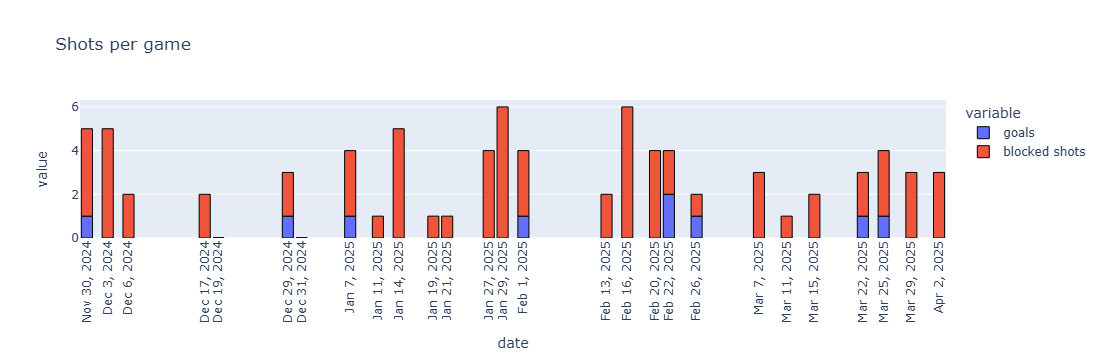

In [237]:
fig = px.bar(fig_df, x="date", y=["goals", "blocked shots"], title="Shots per game", hover_data = {"season": True})
fig.update_xaxes(tickangle=270, tickvals = df["date"])
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

Let’s do a second one. What about the number of points per minute on the ice?

In [217]:
df["time on the ice"].head()

0    15:10
1    17:55
2    16:28
3    15:55
4    17:32
Name: time on the ice, dtype: object

In [221]:
def mm_ss_to_decimal(mm_ss):
    mm, ss = mm_ss.split(":")
    return int(mm) + (int(ss) / 60)

def get_minutes_on_the_ice(row):
    return mm_ss_to_decimal(str(row["time on the ice"]))

fig_df = df
fig_df["minutes on the ice"] = fig_df.apply(lambda row: get_minutes_on_the_ice(row), axis=1)
fig_df[["time on the ice", "minutes on the ice"]].head()

,time on the ice,minutes on the ice
0,15:10,15.166667
1,17:55,17.916667
2,16:28,16.466667
3,15:55,15.916667
4,17:32,17.533333


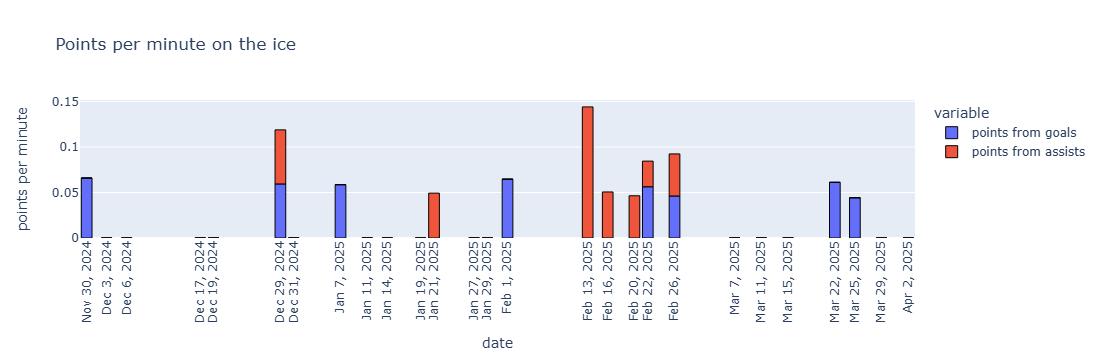

In [231]:
fig_df["points from goals"] = fig_df["goals"] / fig_df["minutes on the ice"]
fig_df["points from assists"] = fig_df["assists"] / fig_df["minutes on the ice"]

fig = px.bar(fig_df, x="date", y=["points from goals", "points from assists"], title="Points per minute on the ice", hover_data = {"season": True})
fig.update_layout(yaxis_title="points per minute")
fig.update_xaxes(tickangle=270, tickvals = df["date"])
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

## Statistics for two skaters

I would like my dashboard to work thusly:

- When initially loading the webpage, no player is selected. A dropdown menu allows for the selection of one.
- When the player is selected, the charts for their positions are loaded with their stats. A new dropdown menu appears, offering a selection of players with the same position. By default, "None" is selected. For instance, selecting forward "MARIE-PHILIP POULIN" in the player selection dropdown will make the second dropdown appear, with "None" selected, the other options being the names of the other forwards in the league.
- If, after selecting a "comparison player" in the second menu, the value of the first menu is changed, the "comparison player" choice will be retained only if the position of the first player remains the same. Otherwise, it will default to "None". For instance, if "MARIE-PHILIPPE POULIN", a forward, is selected in the first menu, and her wife, fellow forward "LAURA STACEY", is selected as the "comparison player", then the user selects another forward, "SARAH NURSE", in the first menu, the "comparison player" will remain "LAURA STACEY" as both selections are forward players. However, if "AERIN FRANKEL", a goalie, is selected in the first menu, the "comparison player" will default to "None" as "LAURA STACEY", a forward player, does not have statistics that can be compared to "AERIN FRANKEL"’s.

Let’s start by seeing how a comparative chart could look like.

In [242]:
df = pd.read_csv("comparison_test.csv")

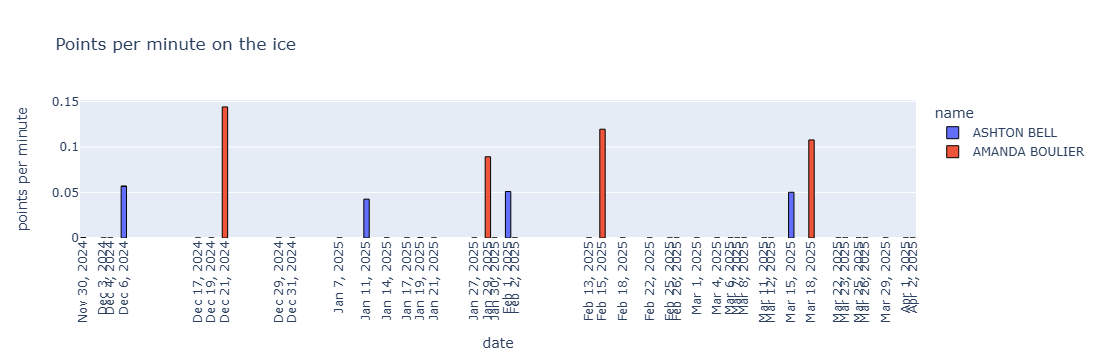

In [246]:
def mm_ss_to_decimal(mm_ss):
    mm, ss = mm_ss.split(":")
    return int(mm) + (int(ss) / 60)

def get_minutes_on_the_ice(row):
    return mm_ss_to_decimal(str(row["time on the ice"]))

fig_df = df
fig_df["minutes on the ice"] = fig_df.apply(lambda row: get_minutes_on_the_ice(row), axis=1)

#fig_df["points from goals"] = fig_df["goals"] / fig_df["minutes on the ice"]
#fig_df["points from assists"] = fig_df["assists"] / fig_df["minutes on the ice"]
fig_df["points per minute"] = fig_df["points"] / fig_df["minutes on the ice"]

#fig = px.bar(fig_df, x="date", y=["points from goals", "points from assists"], title="Points per minute on the ice", hover_data = {"season": True})
fig = px.bar(fig_df, x="date", y="points per minute", color="name", title="Points per minute on the ice", hover_data = {"season": True})
fig.update_layout(yaxis_title="points per minute")
fig.update_xaxes(tickangle=270, tickvals = df["date"])
fig.update_traces(marker_line_color="black", marker_line_width=1)
fig.show()

## TODO

- Write about this notebook in the README file
- Check what the PWHL’s definition of a "game winning goal" is
- Figure out exactly how it is determined which goalie gets the win/loss in their statistics (final goalie or most time on the ice, probably?)
- Add to script TODO: add a comparison mode
- Add to script TODO: add a message for a player with no stats
- Add to README TODO: create a script to update only the latest season in the CSV file containing all game by game stats (so no need to get ALL the stats again from the website)
- Change all specific Fleet positions to F and D
- Add to script TODO: make sure the comparison dropdown doesn’t offer to compare a player with themselves
- Consider enabling F and D comparison